## Importing needed packages

In [298]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
from scipy.stats import norm

## Loading Data from Excel

In [299]:
CapCost = pd.read_excel('Data/CAPEX.xlsx')
OpCost = pd.read_excel('Data/OPEX.xlsx')
TechInfo = pd.read_excel('Data/TechInfo.xlsx')
StorCost = pd.read_excel('Data/StorageCapex.xlsx')
CapLim = pd.read_excel('Data/CapacityLimit.xlsx')
CapExi = pd.read_excel('Data/ExistingCapacity.xlsx')
CapOut = pd.read_excel('Data/CapacityOut.xlsx')
Demand = pd.read_excel('Data/Demand.xlsx')
StorExi = pd.read_excel('Data/ExistingStorage.xlsx')
ProdFacOffWind = pd.read_excel('Data/OffshoreCapacityFactor.xlsx')
ProdFacOnWind = pd.read_excel('Data/OnshoreCapacityFactor.xlsx')
ProdFacSolar = pd.read_excel('Data/SolarCapacityFactor.xlsx')

## Transform data frames into matrix

In [300]:
CapCost = np.array(CapCost['Annualized Investment Cost [EUR/kW]'])
OpCost = np.array(OpCost['Total OPEX'])
#TechInfo = np.array(TechInfo['Type'])
StorCost = np.array(StorCost['CAPEX [EUR/kWh]'])
CapLim = np.array(CapLim['Maximum Capacity [GW]'])
CapExi = np.array(CapExi['Capacity [GW]'])
CapOut = np.array(CapOut['Maximum Capacity [GW]'])
Demand = np.array(Demand['Demand [GWh]'])
StorExi = np.array(StorExi['Capacity [GWh]'])
ProdFacOffWind = np.array(ProdFacOffWind['Capacity Factor'])
ProdFacOnWind = np.array(ProdFacOnWind['Capacity Factor'])
ProdFacSolar = np.array(ProdFacSolar['Capacity Factor'])


## Defining Input Data

In [301]:
# # Create a dataframe for Capacity Cost
# CapCost = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'CapCost[€/MW]': [150, 100, 2500, 9000, 9000]
# })

# # Create a dataframe for Operating Cost
# OpCost = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'OpCost[€/MWh]': [200, 250, 500, 0, 0]
# })

# # Create a dataframe to define general technology information
# TechInfo = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'Type': ['Fossil', 'Fossil', 'Fossil', 'RES', 'RES']
# })

# # Create a dataframe for Storage Cost
# StorCost = pd.DataFrame({
#     'Plant': ['Battery', 'Pumped Hydro'],
#     'StorCost[€/MWh]': [10, 50000000]
# })

# # Create a dataframe for Capacity Limit
# CapLim = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'CapLim[MW]': [100000, 100000, 100000, 10000000, 10000000]
# })

# # Create a dataframe for existing capacity
# CapExi = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'ExCap[MW]': [100, 50, 50, 100, 100]
# })

# # Create a dataframe for outphased capacity
# CapOut = pd.DataFrame({
#     'Plant': ['Coal', 'Gas', 'Nuclear', 'Wind', 'Solar'],
#     'OutCap[MW]': [0, 0, 0, -50, 0]
# })


# # Create a dataframe for demand on hourly basis
# Demand = pd.DataFrame({
#     'Hour': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
#     'Demand[MWh]': [500,60,555,343,644,343,535,223,535,634,90,535,223,535,634,343,535,223,535,634,943,535,223,535]
# })

# Create a dataframe for eta charge
EtaCh = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaCh': [0.9, 0.8]
})

# Create a dataframe for eta discharge
EtaDis = pd.DataFrame({
    'Plant': ['Battery', 'Pumped Hydro'],
    'EtaDis': [0.9, 0.8]
})

# # Create a dataframe for existing storage capacity
# StorExi = pd.DataFrame({
#     'Plant': ['Battery', 'Pumped Hydro'],
#     'ExStor[MWh]': [40, 0]
# })


## Data Sampling

In [302]:


# # Transpose to correct format (Hours × 1 Scenario)
# ProdFacOffWind = ProdFacOffWind.T  # Shape: (24, 1)
# ProdFacSolar = ProdFacSolar.T  # Shape: (24, 1)

# Number of new scenarios to generate
num_scenarios = 2
num_hours = len(Demand)  

# Step 1: Fit Normal Distributions for Each Hour (Using Small Variability)
OffWindDistributions = {}
OnWindDistributions = {}
solar_distributions = {}

for hour in range(num_hours):
    # Offshore Wind
    OffWindMean = ProdFacOffWind[hour]
    Offwind_std_dev = max(0.15 * OffWindMean, 0.05)  # 5% of mean, at least 0.01
    OffWindDistributions[hour] = (OffWindMean, Offwind_std_dev)

    # Onshore Wind
    OnWindMean = ProdFacOnWind[hour]
    Onwind_std_dev = max(0.15 * OnWindMean, 0.05)  # 5% of mean, at least 0.01
    OnWindDistributions[hour] = (OnWindMean, Onwind_std_dev)

    # Solar
    solar_mean = ProdFacSolar[hour]
    solar_std_dev = max(0.05 * solar_mean, 0.01)  # 5% of mean, at least 0.01
    solar_distributions[hour] = (solar_mean, solar_std_dev)

# Step 2: Generate New Scenarios Using Monte Carlo Sampling
Offwind_scenarios = np.zeros((num_hours, num_scenarios))
Onwind_scenarios = np.zeros((num_hours, num_scenarios))
Solar_scenarios = np.zeros((num_hours, num_scenarios))

for scenario in range(num_scenarios):
    for hour in range(num_hours):
        # Offshore Wind Sampling
        OffWindMean, Offwind_std_dev = OffWindDistributions[hour]
        Offwind_sample = np.random.normal(OffWindMean, Offwind_std_dev)
        Offwind_scenarios[hour, scenario] = np.clip(Offwind_sample, 0, 1)

        # Onshore Wind Sampling
        OnWindMean, Onwind_std_dev = OnWindDistributions[hour]
        Onwind_sample = np.random.normal(OnWindMean, Onwind_std_dev)
        Onwind_scenarios[hour, scenario] = np.clip(Onwind_sample, 0, 1)

        # Solar Sampling
        solar_mean, solar_std_dev = solar_distributions[hour]
        solar_sample = np.random.normal(solar_mean, solar_std_dev)
        Solar_scenarios[hour, scenario] = np.clip(solar_sample, 0, 1)

## Defining Input Parameters

In [303]:
# Define number of hours as length of demand
N_Hours = len(Demand)

# Define number of generators as length of CapCost
N_Cap = len(CapCost)

# Define number of storage as length of StorCost
N_Stor = len(StorCost)

# Define number of scenarios as number of columns in ProdFacWind
N_Scen = num_scenarios

# Define epsilon
epsilon = 0.1

#Define delta
delta = 0.2

BigM = 1000000

## Defining classes

In [304]:
# Class for external input data
class InputData():
    def __init__(self, CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Dem,EtaCha,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios):
        self.CapCost = CapCost
        self.OpCost = OpCost
        self.TechInfo = TechInfo
        self.StorCost = StorCost
        self.CapLim = CapLim
        self.CapExi = CapExi
        self.CapOut = CapOut
        self.Dem = Dem
        self.EtaCha = EtaCha
        self.EtaDis = EtaDis
        self.StorExi = StorExi
        self.Offwind_scenarios = Offwind_scenarios
        self.Onwind_scenarios = Onwind_scenarios
        self.Solar_scenarios = Solar_scenarios
        

        

In [305]:
# Class for model parameters
class Parameters():
    def __init__(self, epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM):
        self.epsilon = epsilon
        self.delta = delta
        self.N_Hours = N_Hours
        self.N_Cap = N_Cap
        self.N_Stor = N_Stor
        self.N_Scen = N_Scen
        self.BigM = BigM

## Creating Data and Parameter Objects

In [306]:
ParametersObj = Parameters(epsilon, delta, N_Hours, N_Cap, N_Stor, N_Scen, BigM)
DataObj = InputData(CapCost, OpCost, TechInfo, StorCost, CapLim,CapExi,CapOut,Demand,EtaCh,EtaDis,StorExi, Offwind_scenarios, Onwind_scenarios, Solar_scenarios)


## Creating the Model

In [307]:
# CLASS WHICH CAN HAVE ATTRIBUTES SET

class Expando(object):
    '''
        A small class which can have attributes set
    '''
    pass

In [308]:
# Defining the optimization model class

class CapacityProblem():
    def __init__(self, ParametersObj, DataObj, Model_results = 1, Guroby_results = 1):
        self.P = ParametersObj # Parameters
        self.D = DataObj # Data
        self.Model_results = Model_results
        self.Guroby_results = Guroby_results
        self.var = Expando()  # Variables
        self.con = Expando()  # Constraints
        self.res = Expando()  # Results
        self._build_model() 


    def _build_variables(self):
        # Create the variables
        self.var.CapNew = self.m.addMVar((self.P.N_Cap), lb=0)  # New Capacity for each type of generator technology
        self.var.EGen = self.m.addMVar((self.P.N_Cap, self.P.N_Hours, self.P.N_Scen), lb=0)  # Energy Production for each type of generator technology for each hour and scenario
        self.var.CapStor = self.m.addMVar((self.P.N_Stor), lb=0)  # New storage capacity for each type of storage technology
        self.var.SOC = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # State of charge for each type of storage technology for each hour and scenario  
        self.var.EChar = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy charged for each type of storage technology for each hour and scenario
        self.var.EDis = self.m.addMVar((self.P.N_Stor, self.P.N_Hours,self.P.N_Scen), lb=0)  # Energy discharged for each type of storage technology for each hour and scenario
        self.var.u = self.m.addMVar((self.P.N_Scen), vtype=GRB.BINARY) # Binary variable for each scenario  # Chance for each scenario


    def _build_constraints(self):
        # Limit new capacity by maximum investable capacity for each type of generator technology
        for g in range(self.P.N_Cap):
            self.con.CapLim = self.m.addConstr(self.var.CapNew[g] <= self.D.CapLim[g], name=f'Capacitylimit G_{g}')
        
        # Production limited by sum of new capacity, existing capacity and phased out capacity times the production factor
        for g in range(self.P.N_Cap):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    if self.D.TechInfo['Technology'][g] == 'Wind Offshore':
                         self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= (self.var.CapNew[g] + self.D.CapExi[g] + self.D.CapOut[g]) * self.D.Offwind_scenarios[h,s], name=f'Production limit offshore wind G_{g} H_{h} S_{s}')
                    elif self.D.TechInfo['Technology'][g] == 'Wind Onshore':
                         self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= (self.var.CapNew[g] + self.D.CapExi[g] + self.D.CapOut[g]) * self.D.Onwind_scenarios[h,s], name=f'Production limit onshore wind G_{g} H_{h} S_{s}')
                    elif self.D.TechInfo['Technology'][g] == 'PV':
                         self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= (self.var.CapNew[g] + self.D.CapExi[g] + self.D.CapOut[g]) * self.D.Solar_scenarios[h,s], name=f'Production limit solar G_{g} H_{h} S_{s}')
                    else:
                        self.con.ProdLim = self.m.addConstr(self.var.EGen[g, h,s] <= self.var.CapNew[g] + self.D.CapExi[g] + self.D.CapOut[g], name=f'Production limit convent G_{g} H_{h} S_{s}')
                        


        # Energy Balance constraint - generation and discharge needs to equal demand and charging for each hour and scenario
        for h in range(self.P.N_Hours):
            for s in range(self.P.N_Scen):
                self.con.Balance = self.m.addConstr(gp.quicksum(self.var.EGen[:, h,s]) + gp.quicksum(self.var.EDis[:, h,s]) == self.D.Dem[h] + gp.quicksum(self.var.EChar[:, h,s]), name=f'Energy balance H_{h} S_{s}')

        # Defining RES share as a percentage of total energy demand
        for s in range(self.P.N_Scen):
            self.con.RESShare = self.m.addConstr(self.P.delta * gp.quicksum(self.D.Dem[h] for h in range(self.P.N_Hours)) - gp.quicksum(self.var.EGen[g, h,s] for h in range(self.P.N_Hours) for g in range(self.P.N_Cap) if self.D.TechInfo['Type'][g] == 'RES' )  <= self.P.BigM * (1 - self.var.u[s]), name=f'RES share S_{s}')

        # Defining how many scenarios are allowed to be violated
        self.con.ScenViol = self.m.addConstr(gp.quicksum(self.var.u[s] for s in range(self.P.N_Scen))/self.P.N_Scen >= (1- self.P.epsilon), name=f'Scenario violation')


        # Defining SOC as SOC from previous hour plus energy charged minus energy discharged for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(1, self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.SOC = self.m.addConstr(self.var.SOC[u, h,s] == self.var.SOC[u, h-1,s] + self.var.EChar[u, h-1,s] - self.var.EDis[u, h-1,s], name=f'State of charge U_{u} H_{h} S_{s}')

        # Define SOC for first hour
        for u in range(self.P.N_Stor):
            for s in range(self.P.N_Scen):
                self.con.SOC0 = self.m.addConstr(self.var.SOC[u, 0,s] == (self.D.StorExi[u])*0, name=f'State of charge 0 U_{u} S_{s}')

        # Limit SOC by maximum storage capacity for each type of storage technology
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.SOCLim = self.m.addConstr(self.var.SOC[u, h,s] <= self.var.CapStor[u] + self.D.StorExi[u], name=f'Storage capacity limit U_{u} H_{h} S_{s}')

        # Limit charged energy by capacity minus state of charge for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.ECharLim = self.m.addConstr(self.var.EChar[u, h,s] <= self.var.CapStor[u] + self.D.StorExi[u] - self.var.SOC[u, h,s], name=f'Energy charged limit U_{u} H_{h} S_{s}')

        # Limit discharged energy by state of charge for each hour and scenario
        for u in range(self.P.N_Stor):
            for h in range(self.P.N_Hours):
                for s in range(self.P.N_Scen):
                    self.con.EDisLim = self.m.addConstr(self.var.EDis[u, h,s] <= self.var.SOC[u, h,s], name=f'Energy discharged limit U_{u} H_{h} S_{s}')


        
    
    def _build_objective(self):
        # Objective function
        objective = (gp.quicksum(self.var.CapNew[g] * self.D.CapCost[g] for g in range(self.P.N_Cap))  # Cost for new capacity for each type of generator technology
        + gp.quicksum(self.var.EGen[g,h,s] * self.D.OpCost[g] for g in range(self.P.N_Cap) for h in range(self.P.N_Hours) for s in range(self.P.N_Scen)) # Operating cost for each type of generator technology for each hour and scenario
        + gp.quicksum(self.var.CapStor[u] * self.D.StorCost[u] for u in range(self.P.N_Stor))) # Cost for new storage capacity for each type of storage technology
        self.m.setObjective(objective, GRB.MINIMIZE)


    def _display_guropby_results(self):
        self.m.setParam('OutputFlag', self.Guroby_results)

    
    def _build_model(self):
        self.m = gp.Model('CapacityProblem')
        self._build_variables()
        self._build_constraints()
        self._build_objective()
        self._display_guropby_results()
        self.m.write("CapacityProblem.lp")
        self.m.optimize()
        self._results()
        if self.Model_results == 1:
            self._extract_results()
            

    
    def _results(self):
        self.res.obj = self.m.objVal
        self.res.CapNew = self.var.CapNew.X
        self.res.EGen = self.var.EGen.X
        self.res.CapStor = self.var.CapStor.X
        self.res.SOC = self.var.SOC.X
        self.res.EChar = self.var.EChar.X
        self.res.EDis = self.var.EDis.X
        self.res.u = self.var.u.X
         
        
        #Create Dataframe for new capacity
        self.res.CapNew = pd.DataFrame({
            'Plant': ['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'],
            'CapNew[MW]': self.res.CapNew,
            'CapExi[MW]': self.D.CapExi,
            'CapOut[MW]': self.D.CapOut
        })

        #Create Dataframe for new storage capacity
        self.res.CapStor = pd.DataFrame({
            'Plant': ['Battery', 'Pumped Hydro'],
            'CapStor[MWh]': self.res.CapStor
        })

        # Create DataFrame for scenario violations
        self.res.Violation_Scenarios = pd.DataFrame({
            'Scenario': list(range(self.P.N_Scen)),
            'Violated (1=No, 0=Yes)': self.res.u
        })
        
        
    

        self.res.EGen_Scenarios = {}

        for s in range(self.P.N_Scen):
            # Extract data for scenario `s`
            e_gen_scenario = self.res.EGen[:, :, s].T  # Transpose to match (Hours x Generators)
            soc_scenario = self.res.SOC[:, :, s].T  # (Hours x Storage Technologies)
            echar_scenario = self.res.EChar[:, :, s].T  # (Hours x Storage Technologies)
            edis_scenario = self.res.EDis[:, :, s].T  # (Hours x Storage Technologies)

            # Extract Wind and Solar Production Factors
            Offwind_scenarios = self.D.Offwind_scenarios[:, s]  # Extract Wind Production Factor for scenario `s`
            Onwind_scenarios = self.D.Onwind_scenarios[:, s]  # Extract Wind Production Factor for scenario `s`
            Solar_scenarios = self.D.Solar_scenarios[:, s]  # Extract Solar Production Factor for scenario `s`

            # Convert to DataFrames
            df_scenario = pd.DataFrame(e_gen_scenario, columns=['Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional'])
            df_soc = pd.DataFrame(soc_scenario, columns=['Battery_SOC', 'PumpedHydro_SOC'])
            df_echar = pd.DataFrame(echar_scenario, columns=['Battery_Charge', 'PumpedHydro_Charge'])
            df_edis = pd.DataFrame(edis_scenario, columns=['Battery_Discharge', 'PumpedHydro_Discharge'])
            df_demand = pd.DataFrame({'Demand': self.D.Dem})

            # Add Wind & Solar Production Factors
            df_prod_factors = pd.DataFrame({'OffWind': Offwind_scenarios, 'OnWind': Onwind_scenarios, 'Solar': Solar_scenarios})

            # Add Hour column
            df_scenario['Hour'] = list(range(self.P.N_Hours))

            # Merge all DataFrames
            df_complete = pd.concat([df_scenario, df_soc, df_echar, df_edis, df_demand, df_prod_factors], axis=1)

            # Reorder columns
            df_complete = df_complete[['Hour', 'Offshore', 'Onshore', 'Biomass', 'Lignite', 'Hard Coal', 'Gas', 'Hydrogren', 'Nuclear', 'Solar PV', 'Hydro', 'Other RES', 'Other Conventional',
                                    'Battery_SOC', 'PumpedHydro_SOC',
                                    'Battery_Charge', 'PumpedHydro_Charge',
                                    'Battery_Discharge', 'PumpedHydro_Discharge',
                                    'Demand', 'OffWind','OnWind', 'Solar']]

            # Store in dictionary
            self.res.EGen_Scenarios[f"Scenario_{s}"] = df_complete
    

    def _extract_results(self):
        # Display the objective value
        print('Objective value: ', self.m.objVal)
        # Display the new capacity for each type of generator technology
        print('New capacity for each type of generator technology: ', self.res.CapNew)
        
        #Display new storage capacity for each type of storage technology
        print('New storage capacity for each type of storage technology: ', self.res.CapStor)

        

## Execute the model

In [309]:
CapacityProblem = CapacityProblem(ParametersObj, DataObj)
#CapacityProblem._results()
#CapacityProblem._extract_results()

ResultsCapacity = CapacityProblem.res.CapNew
ResultsStorage = CapacityProblem.res.CapStor
#ResultsViolations = CapacityProblem.res.Violation_Scenarios

for scenario_name, df in CapacityProblem.res.EGen_Scenarios.items():
    df.to_csv(f"{scenario_name}.csv", index=False)  # Save each scenario as a CSV file
    print(f"Saved {scenario_name}.csv")

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 5 5500U with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 367935 rows, 315376 columns and 1202680 nonzeros
Model fingerprint: 0x2a14becb
Variable types: 315374 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e-06, 1e+06]
  Objective range  [2e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-05, 1e+07]
Presolve removed 128877 rows and 58785 columns
Presolve time: 1.53s
Presolved: 239058 rows, 256591 columns, 851120 nonzeros
Variable types: 256591 continuous, 0 integer (0 binary)
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.26s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 7.697e+05
 Factor NZ  : 4.088e+06 (roughly 230 MB of m

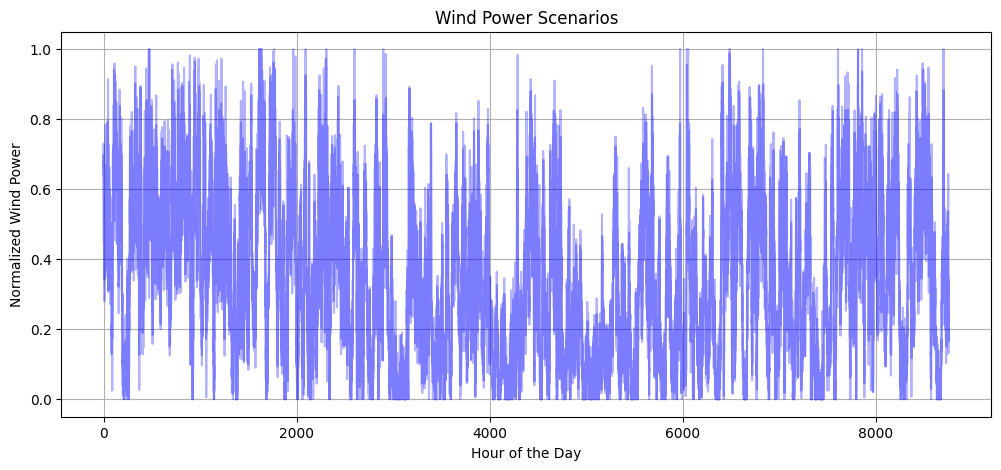

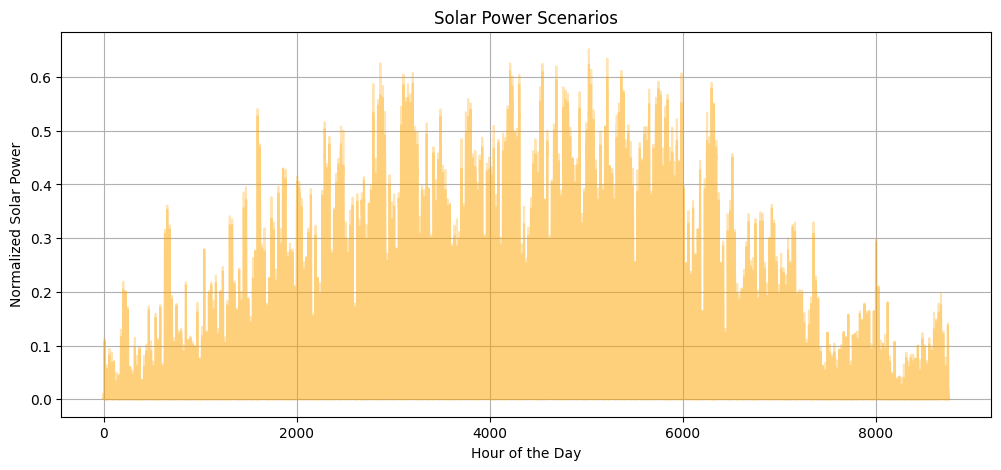

In [310]:
import matplotlib.pyplot as plt

# Plot Wind Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(num_hours), Offwind_scenarios[:, scenario], alpha=0.3, color='blue')
plt.title("Wind Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Wind Power")
plt.grid(True)
plt.show()

# Plot Solar Scenarios
plt.figure(figsize=(12, 5))
for scenario in range(N_Scen):  # Plot only first 50 scenarios for clarity
    plt.plot(range(num_hours), Solar_scenarios[:, scenario], alpha=0.3, color='orange')
plt.title("Solar Power Scenarios")
plt.xlabel("Hour of the Day")
plt.ylabel("Normalized Solar Power")
plt.grid(True)
plt.show()
